# Building A Better Dish Finder

## The goal of the project is to build an app that allows a user to find local resturants and eateries that specialize in a specific dish. This could be anything - bagels, pizza, chicken wings, tacos. We are looking to redefine what it means for a resturant to be "good", as many resturants specialize in certain dishes.

## The dataset can be found at https://www.yelp.com/dataset.

In [26]:
import numpy as np
import time
import scipy
import pandas as pd
import dask.bag as db
import json
import matplotlib.pyplot as plt
import arviz as az
import pymc3 as pm
import mplleaflet
import folium
import geopandas
from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
from scipy.special import factorial as factorial
%matplotlib notebook
pd.set_option('display.max_columns', None)

## Here we will focus on a specific data set, the Toronto data, and work to increase the speed of the bayseian inferance

In [5]:
Toronto = pd.read_csv('toronto.csv')

### We can use a bayesian  model in order to sample from the posterior distribution. Here, we use the total resturant reviews in order to inform the prior distribution of the quality of the individual dish. This should make intutive sense - the better the resturant is, the more likely it will be that a specific dish is good. The worse a resturant is, the less likely. By using the total resturant information as the prior, we are biasing our results towards the general quality of the resturant. But if a specific dish is really good (or really bad), this will show up when we calculate the likelihood


# $P(\lambda_{taco} \vert $reviews$) \propto P($reviews of tacos$ \vert \lambda_{taco}) * P(\lambda_{all} \vert $reviews$)$

### Where the likelihood is defined as

# $P($reviews $\vert \lambda)$ = $\prod P(k_{stars}, \lambda)$ = $\prod \lambda^k e^{-\lambda}/Zk! $

### with k the number of stars awarded (from 0 to 4) and Z the normalization so the probability sums to 1

In [6]:
def Z(lam):
    return np.exp(-lam)*(1 + lam + lam**2/2 + lam**3/6 + lam**4/(6*4))

def poisson_prob(lam):
    vec = []
    for k in range(5):
        vec.append(lam**k * np.exp(-lam)/(Z(lam)*np.math.factorial(k)))
    return vec

def likelihood(lam,k):
    logprob = (k*np.log(lam) - lam - np.log(Z(lam)) - np.log(factorial(k))).sum()
    return logprob

### We can test this one just a single business to start

In [8]:
businesses = Toronto[Toronto['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)]['business_id'].value_counts().index.to_list()

sb = Toronto[Toronto['business_id'] == businesses[10]]
allstars = sb.stars_y.to_list() 
fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)].stars_y.to_list()
    
    
with pm.Model() as test_model:

    lam_resturant = pm.Uniform('lam_rest',0,10)
    y_obs_2 = pm.Potential('y_obs_2',likelihood(lam_resturant,np.array(allstars)-1))
    
    lam_taco = pm.Normal('lam_tacos',mu=lam_resturant,sd=np.sqrt(lam_resturant))
    y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(fooditem_stars)-1))

with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [lam_tacos]
>Metropolis: [lam_rest]
Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:09<00:00, 6458.15draws/s]
The number of effective samples is smaller than 25% for some parameters.


### And see what the predicted taco score is ($\lambda_{taco}$ in the model). These plots give the probability density of specific parameters, along with the sampling paths for each parameter. This gives us far more information than just a mean and standard deviation, which could be used in further analysis to fine tune our scoring

<IPython.core.display.Javascript object>


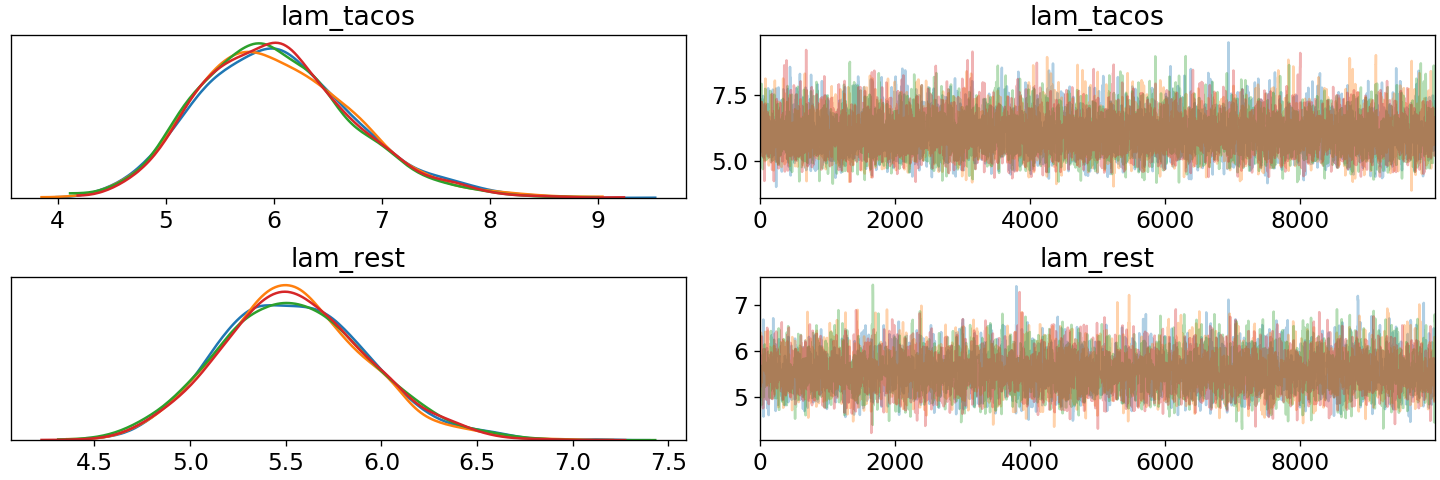

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12733ae80>,
      dtype=object)

In [15]:
pm.traceplot(trace)

In [19]:
varnames = ['~mu']
az.summary(trace,varnames,credible_interval=.93).round(3)

,mean,sd,hpd_3.5%,hpd_96.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_tacos,6.027,0.711,4.747,7.275,0.008,0.005,8680.0,8543.0,8865.0,9161.0,1.0
lam_rest,5.546,0.383,4.837,6.220,0.004,0.003,7548.0,7491.0,7628.0,7410.0,1.0


### A key question would be to see if this actually does any better at predicting how highly people will rate tacos. We can compare it to just the base model. Here, we actually see that the resturant in question scores higher for its tacos than it does overall! Those must be good tacos

### Another question is, would we just be better off using the taco only data?

In [20]:
sb = Toronto[Toronto['business_id'] == businesses[10]]
allstars = sb.stars_y.to_list() 
fooditem_stars = sb[sb['text'].str.contains('tacos|taco|tacco|tco|carnitas|barbacoa|al pastor',regex=True)].stars_y.to_list()
    
    
with pm.Model() as test_model:

    lam_taco = pm.Uniform('lam_taco',0,10)
    y_obs = pm.Potential('y_obs',likelihood(lam_taco,np.array(fooditem_stars)-1))

with test_model:
    step = pm.Metropolis()
    trace = pm.sample(10000,step=step,tune=5000)

Sampling 4 chains, 0 divergences: 100%|██████████| 60000/60000 [00:07<00:00, 8358.10draws/s]


<IPython.core.display.Javascript object>


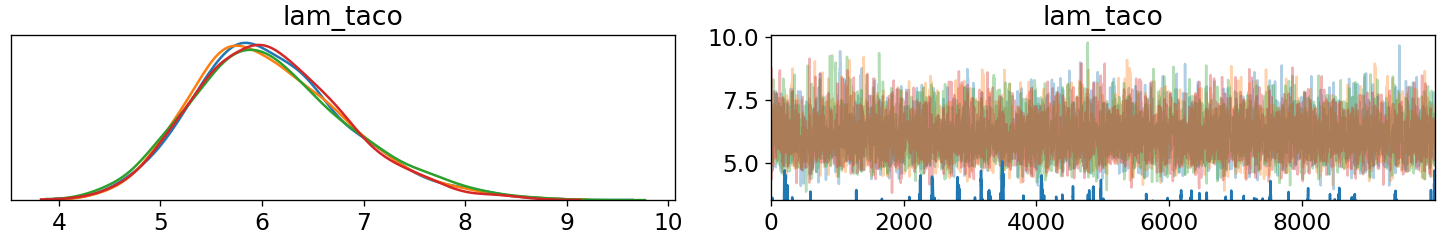

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x129b05c18>,
      dtype=object)

In [21]:
pm.traceplot(trace)

In [22]:
az.summary(trace,varnames,credible_interval=.93).round(3)

,mean,sd,hpd_3.5%,hpd_96.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lam_taco,6.1,0.767,4.746,7.494,0.009,0.007,7198.0,6877.0,7627.0,7002.0,1.0


# Addition (7/9/20): Although using pymc3 to get the taco score is highly robust, it is admittedly (very) slow. We can increase the speed by noting that the distributions we are using are not very complicated, and can build our own metropolis sampler

## The first step is to find a reasonable starting point for our sampling. Given a list of star reviews, we can compute the most probable value of $\lambda$ for our distribution by taking a derivative of the likelihood with respect to $\lambda$. Then, we can use a metropolis sampler with uniform prior (from 0 to maxlambda) in order get a rough sample of the distribution


--- 0.1819291114807129 seconds ---


Text(0, 0.5, 'Probability Density')

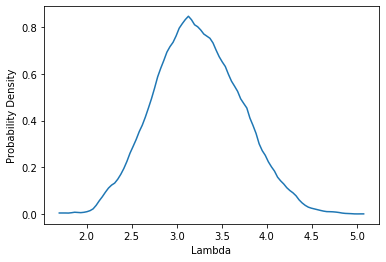

In [10]:
def func(lam,stars):
    N = len(stars)
    sumval = sum(stars)
    return -N + sumval/lam + lam**4/(24*(1+lam+lam**2/2+lam**3/6+lam**4/24))

def logp(lam,stars):
    N = len(stars)
    return -N*lam + sum(stars)*np.log(lam) - np.log(Z(lam))

def step(lam,stars,maxlam,delta):
    newlam = lam + delta*np.random.uniform(-1,1)
    if (newlam > maxlam) or (newlam < 0):
        return lam
    oldp = logp(lam,stars)
    newp = logp(newlam,stars)
    if np.random.uniform(0,1) < np.exp(newp - oldp):
        return newlam
    else:
        return lam
    
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
    
def return_lam_samples(stars,maxlam):
    delta = .5 #reasonable value to take, considering spread is rather small
    numsamps = 10000 #Good sampling value
    try:
        results = scipy.optimize.root_scalar(func,args=stars,bracket=[.1,100],method='brentq')
        start = results.root
    except:
        print('setting start lambda to max value')
        start = maxlam
        
        
    lam = [start]
    for i in range(numsamps):
        lam.append(step(lam[-1],stars,maxlam,delta))
    return lam

def step_with_prior(lam,stars,maxlam,delta,prior):
    prior_index = prior[0]
    prior_prob = prior[1]
    
    newlam = lam + delta*np.random.uniform(-1,1)
    if (newlam > maxlam) or (newlam < 0):
        return lam
   
    oldp = logp(lam,stars) +  np.log(prior_prob[find_nearest(prior_index,lam)])
    newp = logp(newlam,stars) +  np.log(prior_prob[find_nearest(prior_index,newlam)])
    if np.random.uniform(0,1) < np.exp(newp - oldp):
        return newlam
    else:
        return lam
    
def return_lam_samples_with_prior(stars,maxlam,prior):
    delta = .5 #reasonable value to take, considering spread is rather small
    numsamps = 20000 #Good sampling value, we want to take more since this will be the final output
    
    lam = [3]
    for i in range(numsamps):
        lam.append(step_with_prior(lam[-1],stars,maxlam,delta,prior))
    return lam[100:]

def pdf_from_stars(stars,maxlam):
    lams = return_lam_samples(stars,maxlam)
    sortedVals = np.sort(lams)
    lamvals = np.linspace(min(sortedVals),max(sortedVals),100)
    count = 0

    CDF = np.zeros(100)


    for i in range(len(lamvals)):
        while sortedVals[count] < lamvals[i]:
            count += 1
        CDF[i] = count

    CDF = CDF/len(sortedVals)
    CDF = scipy.signal.savgol_filter(CDF,5,1)
    pdf = np.gradient(CDF,lamvals)
    return lamvals,pdf

start_time = time.time()
    
allstars_test = [1,4,4,4,2,2,3,2,2,4,4,4,4,4,3]
results = pdf_from_stars(allstars_test,10)
print("--- %s seconds ---" % (time.time() - start_time))
plt.figure()
plt.plot(results[0],results[1])
plt.xlabel('Lambda')
plt.ylabel('Probability Density')

## As we can see, this very quickly gets a good estimate of the prior for $\lambda_{taco}$. The next step would be to get a sampling of the taco stars likelihood, given this prior. This is easy since we already have the prior distribution for the resturant stars. 

## $P(\lambda_{tacos}) = \sum_{\lambda} P(\lambda_{tacos} \vert \lambda) * P(\lambda)$
## We can model the conditional probability as a gaussian with std ~1 (indicating uncertainty in the relation between a good resturant and good tacos)

--- 0.03266620635986328 seconds ---


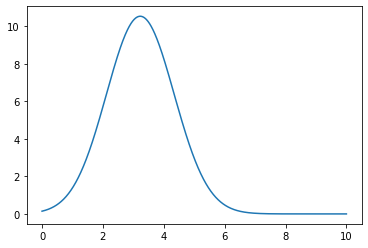

In [12]:
def specific_pdf(pdf,maxlam):
    pdf_index = pdf[0]
    pdf_values = pdf[1]
    specific_pdf_index = np.linspace(0,maxlam,1000)
    specific_pdf_values = np.zeros(1000)
    count = 0
    for value in specific_pdf_index:
        specific_pdf_values[count] = sum(1/np.sqrt(2*np.pi) * np.exp(-(value-pdf_index)**2/(2)) * pdf_values)
        count += 1
    return specific_pdf_index,specific_pdf_values

start_time = time.time()
newresults = specific_pdf(results,10)
print("--- %s seconds ---" % (time.time() - start_time))

plt.figure()
plt.plot(specific_pdf(results,10)[0],specific_pdf(results,10)[1])

## This piece is also extremely fast!

## Next we will put it all togeather in a single function in order to sample the full distribution

--- 0.8719680309295654 seconds ---


(array([0.00177021, 0.        , 0.00177021, 0.        , 0.00177021,
        0.        , 0.00442551, 0.00442551, 0.00619572, 0.01150634,
        0.01504675, 0.02743818, 0.05399126, 0.03097859, 0.08142945,
        0.05841678, 0.0973613 , 0.11329315, 0.12037397, 0.14692705,
        0.17170992, 0.20003321, 0.1973779 , 0.23809263, 0.27084142,
        0.32483269, 0.34873046, 0.35846659, 0.40006642, 0.36554741,
        0.48415117, 0.45317258, 0.51689997, 0.491232  , 0.525751  ,
        0.53548713, 0.56027001, 0.52840631, 0.50804895, 0.53548713,
        0.56204021, 0.53371693, 0.50716384, 0.47795546, 0.48503628,
        0.47795546, 0.40095152, 0.45140237, 0.42130888, 0.37970906,
        0.3947558 , 0.34696026, 0.34164964, 0.30624553, 0.26818612,
        0.30447533, 0.23189691, 0.2292416 , 0.20180341, 0.18144605,
        0.163744  , 0.14958236, 0.11152294, 0.12037397, 0.12479948,
        0.0663827 , 0.0654976 , 0.05487637, 0.06372739, 0.03982962,
        0.04337003, 0.05310616, 0.02920839, 0.02

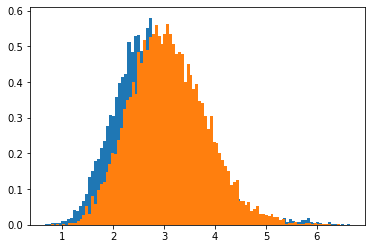

In [13]:
def full_lambda_samples(allstars,specificstars,maxlam):
    pdf = pdf_from_stars(allstars,maxlam)
    specific_prior_pdf = specific_pdf(pdf,maxlam)
    
    return return_lam_samples_with_prior(specificstars,maxlam,specific_prior_pdf)


    
    
start_time = time.time()
newresults = full_lambda_samples([1,1,2,3,3,3,4],[2,3,3],10)
print("--- %s seconds ---" % (time.time() - start_time))

plt.figure()
plt.hist(full_lambda_samples([1,1,2,3,3,3,4],[2,3,3],10),bins=100,density=True)
plt.hist(full_lambda_samples([1,1,2,3,3,3,4],[2,3,4],10),bins=100,density=True)


## This takes quite a bit longer, but still is reasonable - 2 seconds per sample. Additionally, we can see that shifting one of the stars from the subset of all reviews can have a significant role in changing our final distribution

# Now that we have our final function, we can quickly compare different businesses. We are also going to have to narrow our search, since the search time is going to become unreasonably long. How long would a user really wait for some search results? Maybe 30 seconds, a minute? We are going to have to pick out the top 15 most likely candidates until we have a faster algorithm in real time, but this allows us to quickly query the database in a reasonable amount of time (a couple of minutes) on our end.

## For instance, we can query the top 100 mentions of chocolate croissants to find the best croissants in Toronto

In [14]:
def search(keyword,df):
    businesses = df[df['text'].str.contains(keyword,regex=True)]['business_id'].value_counts().index.to_list()
    try:
        businesses = businesses[:100]
    except:
        businesses = businesses
    
    
    foodscore_dict = {}
    fooddiv_dict = {}
    ratio_dict = {}
    
    samples_dict = {}
    
    for business in businesses:
        sb = df[df['business_id'] == business]
        allstars = sb.stars_y.to_list() 
        fooditem_stars = sb[sb['text'].str.contains(keyword,regex=True)].stars_y.to_list()
        samples = full_lambda_samples(allstars,fooditem_stars,10)
        
        foodscore_dict.update({business : np.mean(samples)/np.sqrt(np.std(samples))})
        ratio_dict.update({business : len(fooditem_stars)/len(allstars)})
        
        name = sb['name'].to_list()[0]
        
        samples_dict.update({name: samples})
        
        
    df['taco'+' score'] = df['business_id'].map(foodscore_dict)
    df['taco'+' ratio'] = df['business_id'].map(ratio_dict)
    
    
    
    newdf = df.groupby('name').mean().sort_values('taco'+' score',ascending=False)
    newdf = newdf[newdf['taco'+ ' score'].notna()]
    
    newdf['Weighted ' + 'taco' + ' score'] = newdf['taco' + ' score']*np.exp(newdf['taco' + ' ratio']/2)
    newdf = newdf.sort_values('Weighted ' + 'taco' + ' score',ascending=False)
    
    
    
    
    namelist = newdf.index.to_list()
    
    samples = []
    for name in namelist:
        samples.append(samples_dict.get(name))
        
    
    
    return newdf,samples

choccroissants,samples = search('chocolate croissant',Toronto)



In [15]:
choccroissants

,Unnamed: 0,is_open,latitude,longitude,stars_x,cool,funny,stars_y,simid,usid,taco score,taco ratio,Weighted taco score
name,,,,,,,,,,,,,
The Danish Pastry House,6.084036e+05,1.000000,43.639492,-79.411129,4.000000,1.467391,0.739130,4.065217,2240.869565,39653.739130,6.177990,0.171053,6.729625
Nadege,1.833113e+06,0.970455,43.649630,-79.406857,3.970455,0.618182,0.377273,3.931818,2891.154545,37902.593182,6.486601,0.042155,6.624772
Bonjour Brioche,2.813222e+06,1.000000,43.659951,-79.345613,3.500000,0.635762,0.539735,3.539735,3282.000000,38636.566225,5.719172,0.066225,5.911719
Gouter,3.123818e+06,1.000000,43.728853,-79.431599,4.500000,9.142857,4.214286,4.285714,942.000000,42825.714286,5.310173,0.214286,5.910718
Butter Baker,1.559797e+06,1.000000,43.655837,-79.384456,4.000000,0.612022,0.163934,4.087432,3486.000000,43017.196721,5.622096,0.049180,5.762058
Absolute Bakery & Cafe,2.311534e+06,0.918367,43.668414,-79.367387,4.000000,1.897959,1.387755,4.224490,5426.959184,36201.755102,5.438133,0.066667,5.622460
Delysees,5.185020e+05,0.000000,43.647221,-79.380366,4.500000,0.576687,0.355828,4.300613,212.000000,39317.036810,5.443839,0.036810,5.544960
Miku,1.266178e+06,1.000000,43.641235,-79.377370,4.000000,0.392622,0.175231,4.221344,183.000000,39929.853755,5.519277,0.006588,5.537486
Cob's Bread,3.334826e+06,1.000000,43.676702,-79.357490,5.000000,0.500000,0.000000,5.000000,3626.000000,35981.750000,5.184423,0.125000,5.518790


## We can examine what the posterior distribution looks like for the first sample, to get an idea of the entire range of croissant scores we would be likely to see if a consumer went to the resturant

[Text(0, 0.5, 'Probability'),
 (0, 10),
 Text(0.5, 0, 'Score'),
 Text(0.5, 1.0, 'Croissant Score')]

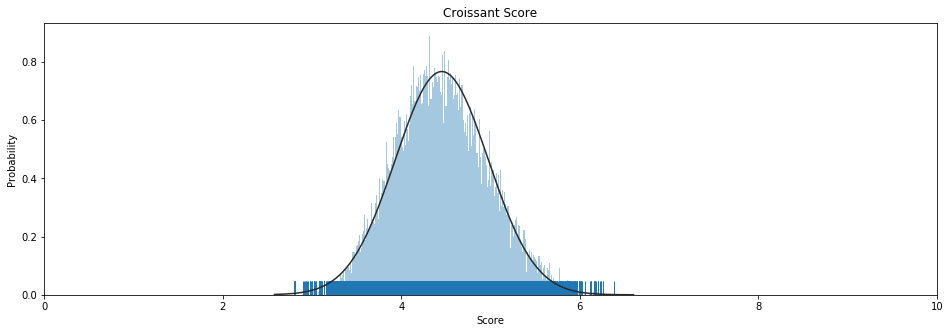

In [16]:
import seaborn as sns
from scipy.stats import norm
plt.figure(figsize=(16,5))
ax = sns.distplot(samples[0],fit=norm,rug=True,bins=300,kde=False)
ax.set(xlabel='Score',ylabel='Probability',title='Croissant Score',xlim=[0,10])

#sns.xlabel('Hello')

## Seeing the entire distribution makes us more confident that, for this resturant (The Danish Pastry House), the user is likely to have a good experiance

[Text(0, 0.5, 'Probability'),
 (0, 10),
 Text(0.5, 0, 'Score'),
 Text(0.5, 1.0, 'Croissant Score')]

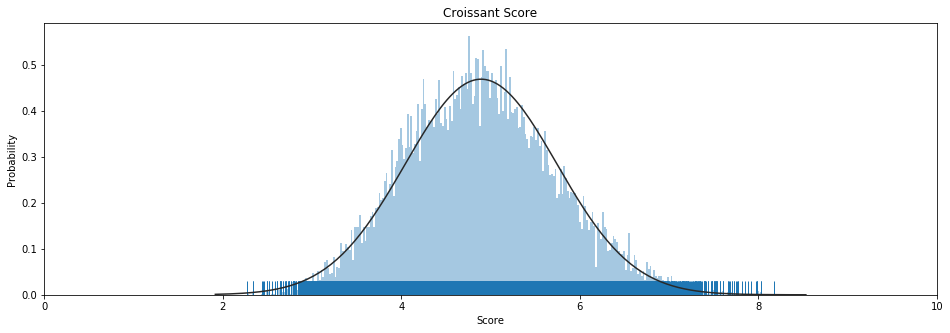

In [18]:
import seaborn as sns
from scipy.stats import norm
plt.figure(figsize=(16,5))
ax = sns.distplot(samples[3],fit=norm,rug=True,bins=300,kde=False)
ax.set(xlabel='Score',ylabel='Probability',title='Croissant Score',xlim=[0,10])

#sns.xlabel('Hello')

## In this case, the Gouter resturant has a much larger range of scores, indicating uncertainty in the result and uncertainty in what a user's experiance will be

# We can use Folium in order to generate really nice interactive maps

In [27]:

def plot_map(df):
    html = """
    Resturant Name: <td>{}</td>
    <br> Food Score: <td>{}</td>
    
    """.format
    
    tacos = df
    tacos['Weighted taco score 2'] = (tacos['Weighted taco score'] - min(tacos['Weighted taco score']))/(max(tacos['Weighted taco score']) - min(tacos['Weighted taco score']))
    toptacos = tacos[:10]
    othertacos = tacos[10:]
    gdf_top = geopandas.GeoDataFrame(toptacos, geometry=geopandas.points_from_xy(toptacos.longitude, toptacos.latitude))
    gdf_top.crs = {'init' :'epsg:4326'}
    
    # Get x and y coordinates for each point
    gdf_top["x"] = gdf_top["geometry"].apply(lambda geom: geom.x)
    gdf_top["y"] = gdf_top["geometry"].apply(lambda geom: geom.y)


    gdf_other = geopandas.GeoDataFrame(othertacos, geometry=geopandas.points_from_xy(othertacos.longitude, othertacos.latitude))
    gdf_other.crs = {'init' :'epsg:4326'}
    
    # Get x and y coordinates for each point
    gdf_other["x"] = gdf_other["geometry"].apply(lambda geom: geom.x)
    gdf_other["y"] = gdf_other["geometry"].apply(lambda geom: geom.y)
    
    #First we deal with the not highly rated resturants

      
    gdf_all = geopandas.GeoDataFrame(tacos, geometry=geopandas.points_from_xy(tacos.longitude, tacos.latitude))
    gdf_all.crs = {'init' :'epsg:4326'}
    
    # Get x and y coordinates for each point
    gdf_all["x"] = gdf_all["geometry"].apply(lambda geom: geom.x)
    gdf_all["y"] = gdf_all["geometry"].apply(lambda geom: geom.y)
    
    # Create a list of coordinate pairs
    locations_with_weights = list(zip(gdf_all["y"], gdf_all["x"],np.exp(5*(gdf_other['Weighted taco score 2']-.3))))
    
    locations = list(zip(gdf_other["y"], gdf_other["x"]))

   
    m = folium.Map(location=[43.65,-79.38], tiles = 'cartodbpositron', zoom_start=11, control_scale=True)

    width, height = 300,50
    popups, locations,icons = [], [],[]

    for idx, row in gdf_other.iterrows():
        locations.append([row['geometry'].y, row['geometry'].x])
        name = idx
    
        iframe = folium.IFrame(html(name,row['Weighted taco score 2']), width=width, height=height)
        popups.append(folium.Popup(iframe))
        icons.append(folium.Icon(icon='info',prefix='fa'))
    
    h = folium.FeatureGroup(name='Resturant')

    h.add_child(MarkerCluster(locations=locations,icons=icons, popups=popups))
    m.add_child(h)


    points_gjson = folium.features.GeoJson(gdf_other, name="Tacos")
    HeatMap(locations_with_weights,min_opacity=.3).add_to(m)
    
    
    #Now we deal with the highly rated resturants
    locations = list(zip(gdf_top["y"], gdf_top["x"]))
    
    popups, locations,icons = [], [],[]

    for idx, row in gdf_top.iterrows():
        locations.append([row['geometry'].y, row['geometry'].x])
        name = idx
    
        iframe = folium.IFrame(html(name,row['Weighted taco score 2']), width=width, height=height)
        popups.append(folium.Popup(iframe))
        icons.append(folium.Icon(color='lightred',icon='thumbs-up',prefix='fa'))
    
    h2 = folium.FeatureGroup(name='Top Resturant')
    for i in range(len(icons)):
        h2.add_child(folium.Marker(location=locations[i],icon=icons[i],popup=popups[i]))

    m.add_child(h2)
    display(m)
    m.save('taco_map.html')

    
plot_map(choccroissants)

/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://